In [42]:
##### Import libraries and define helper functions
#import ipy_autoreload
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
###### fix notebook theme: make cells wide and add a margin to output cells
from IPython.core.display import display, HTML
display(HTML("""
<style>
  .container { width:99% !important; } 
  div.cell{
    width:100%;
    margin-left:1%;
    margin-right:auto;
  }
  div.output_area {
   display: -webkit-box;
   padding: 13px;
  }
</style>"""))
#################################
import re
import time
import os
import sys, traceback
import gc
import numpy as np
#to dump objects
import cPickle as pickle
import operator
import itertools

import matplotlib
#matplotlib.use('PDF')
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib as mpl
fm = mpl.font_manager
fm.get_cachedir()
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import pylab
from numpy.core.function_base import linspace
from numpy.lib.function_base import meshgrid
from numpy.core.numeric import array
from matplotlib import colors
from mpl_toolkits.mplot3d.axes3d import Axes3D
#from mpl_toolkits import mplot3d
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import colorConverter

from matplotlib import cm
from collections import OrderedDict, Set

######################################################
#constants
experiment_time_stamp_idx=0
ble_mode_idx=1
tx_power_idx=2
tx_offset_idx=3
capture_idx=4
prr_1_idx=5
prr_2_idx=6
prr_ct_idx=7
rssi_avg_idx=8
rssi_stddev_idx=9
ts_delta_avg_idx=10
ts_delta_stddev_idx=11

class expdesc_usage_class:
  ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed = range(0,11)

class expsummary_usage_class:
  avg_per, stddev_per, avg_hopcount, stddev_hopcount, avg_onslots, stddev_onslots = range(0,6)

expdesc_usage = expdesc_usage_class()
expsummary_usage = expsummary_usage_class()
#constatnts
Ble_1Mbit=3 #/*!< 1 Mbit/s Bluetooth Low Energy */
Ble_2Mbit=4 #/*!< 2 Mbit/s Bluetooth Low Energy */
Ble_LR125Kbit=5 #/*!< Long range 125 kbit/s (TX Only - RX supports both) */
Ble_LR500Kbit=6 #/*!< Long range 500 kbit/s (TX Only - RX supports both) */
IEER802154_250Kbit=15
ble_mode_str_list = ["1Mbps", "2Mbps", "LR-125Kbps", "LR-500Kbps", "IEEE 802.15.4"]
ble_mode_str_list_compact = ["1 M", "2 M", "125 K", "500 K", "802.15.4"]
blueFloodSlotSizes = {Ble_1Mbit:0.5325, Ble_2Mbit:0.3636, Ble_LR500Kbit:1.324, Ble_LR125Kbit:3.677, IEER802154_250Kbit:1.829}
#ble_mode_str_dict = {Ble_1Mbit: "1Mbps", Ble_2Mbit:"2Mbps", Ble_LR125Kbit:"LR-125Kbps", Ble_LR500Kbit:"LR-500Kbps"}
ble_mode_str_dict = {Ble_1Mbit: "1 M", Ble_2Mbit:"2 M", Ble_LR125Kbit:"125 K", Ble_LR500Kbit:"500 K", IEER802154_250Kbit:"802.15.4"}

def ble_mode_str(m):
  return ble_mode_str_list[m-3] if (m>=3 or m<=6) else ("RF Mode Unknown %d" %(m))

def ble_mode_str_compact(m):
  return ble_mode_str_list_compact[m-3] if (m>=3 or m<=6) else ("RF Mode Unknown %d" %(m))

plot_ts_delta_over = False
plot_rssi_diff_over = False

linestylesDict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
#linestyles = linestylesDict.items()
linestyles = ['-', '--', '-.', ':',linestylesDict['densely dotted']]
markers = ['o', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'v', '^', '<', '>',]

def timing(f):
  def wrap(*args, **kwargs):
    time1 = time.time()
    ret = f(*args, **kwargs)
    time2 = time.time()
    print '%s function took %f ms' % (f.func_name, (time2-time1)*1000.0)
    return ret
  return wrap

def saveObject(userobj, filename):
    with open(filename, 'wb') as outputFile:
        pickle.dump(userobj, outputFile, pickle.HIGHEST_PROTOCOL)

def loadObject(filename):
    userobj = None
    with open(filename, 'rb') as inputFile:
        userobj = pickle.load(inputFile)
    return userobj

def tx_status_map_bad_rx(t):
  ''' 
  '-': rx ok
  '1': mote 1 tx
  '2': mote 2 tx
  'B': both tx
  ':': skipped slot
  ''' 
  if(t in ['-', '1', '2', 'B', ':', 'X', '\0']):
    return 0
  else:
    return 1

def tx_status_map_tx(t):
  ''' 
  '-': rx ok
  '1': mote 1 tx
  '2': mote 2 tx
  'B': both tx
  ':': skipped slot
  ''' 
  if(t in ['1', '2', 'B', 'X']):
    return 1
  else:
    return 0

def tx_status_map_tx2(t):
  ''' 
  '-': rx ok
  '1': mote 1 tx
  '2': mote 2 tx
  'B': both tx
  ':': skipped slot
  ''' 
  if(t in ['-', ':']):
    return 0
  elif(t in ['1', '2', 'B', 'X']):  
    return 1
  else:
    return 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
#### Functions to parse experiment logs, for Graz testbed
##############
#12345_2019_12_18_18_05_59_dirty-channel__ble_mode_6_txpower_4_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_GRAZ_TESTBED None
expname_regex = re.compile("(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)(?:_dirty-channel)?_?_ble_mode_(\d+)_txpower_(-?\d+)_txoffset_(-?\d+)_capture_(\d)(_packet_size_(\d+))?(_nch_(\d+))?(_och_(\d+))?(_ntx_(\d+))?(_i_(\d+))?(_testbed_(\w+)_TESTBED)?")
def parse_experiment_name(expname, nch=1, och=1, ntx=4, packet_size = 38):
  res = expname_regex.match(expname)
  #print dirname
  parsed = None
  if res:
    exp_number = int(res.group(1))
    ts = [int(res.group(2)), int(res.group(3)), int(res.group(4)), int(res.group(5)), int(res.group(6)),int(res.group(7))]
    ble_mode = int(res.group(8))
    txpower = int(res.group(9))
    txoffset = int(res.group(10))
    capture = int(res.group(11))
    initiator = None
    testbed = None
    if res.group(12):
        if str(res.group(12)).startswith("_packet_size_"):
            packet_size = int(res.group(13))
    if res.group(14):
        if str(res.group(14)).startswith("_nch_"):
            nch = int(res.group(15))
    if res.group(16):
        if str(res.group(16)).startswith("_och_"):
            och = int(res.group(17))
    if res.group(18):
        if str(res.group(18)).startswith("_ntx_"):
            ntx = int(res.group(19))
    if res.group(20):
        if str(res.group(20)).startswith("_i_"):
            initiator = int(res.group(21))       
    if res.group(22):
        if str(res.group(22)).startswith("_testbed_"):
            testbed = str(res.group(23))   
    parsed = [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
  return parsed

#2019-12-19 00:32:53.102248|{tx-49} :B---AAAAAAAAAA...
#1574953250505373 {tx-111} :BCB-CAAAAA....
line_tx_regex = re.compile("(.*)[\s\|]\{tx-(\d+)\}\s(.*)")
def parse_tx_experiment_line(line):
  #93_2018_08_20_13_12_56_ble_mode_3_txpower_-20_txoffset_0_capture_0
  res = line_tx_regex.match(line)
  parsed = None
  if res:
    tsstr = str(res.group(1))
    rd = int(res.group(2))
    lline = str(res.group(3))
    parsed = tsstr, rd, lline
  return parsed

def process_tx_status(lline):
  lline=str(lline)
  is_initiator=False; synced=-1; sync_slot=-1; tot=0
  if len(lline) > 1: #and len(lline) <= Round.ROUND_LEN+1:
#                 if(len(lline)<Round.ROUND_LEN):
#                     lline = lline.rjust(Round.ROUND_LEN+ 1, "A")
#                     lline=lline.replace(':','A') #replace 
    ch=lline[1]
    #replace left dots with the letter, and remove the right dots!
    lline=re.sub(r'\.*$',r'',lline) #remove trailing dots
    lline=lline.replace('.',ch) #replace left dots with the first letter
    tx_status = lline[1:]  #remove ":"                  
    #print self.tx_status
    is_initiator, sync_slot, tot = [False, -1, 0]
    if len(tx_status) > 0:
      synced = tx_status.find("-") 
      sync_slot = 1 + synced if synced != -1 else -1  #first rx ok
      is_initiator = tx_status[0] in ['B', '1', '2']
      if is_initiator:
        sync_slot = 0

      tot=len(tx_status)
    
  return is_initiator, sync_slot, tot 


###############
testbeds={"GRAZ", "CAU", "HOME"}
def load_testbed_node_log_files(dirname, testbed="GRAZ"):
  #experiment_parameters
  dn = os.path.basename(os.path.normpath(dirname))
  if(testbed == "GRAZ"):
    exp_number = int(dn.split("_")[1])
    logfilename_regex = re.compile("log_(\d+)\.txt")
  else:
    exp_number = int(dn.split("_")[0])
    logfilename_regex = re.compile("raspi(\d+)")
    dirname = os.path.join(dirname, "logs")
  files=os.listdir(dirname)
  files.sort()
  nodes = dict()
  for nodefile in files:    
    fpath = os.path.join(dirname, nodefile)
    if(testbed == "GRAZ"):
      if not os.path.isfile(fpath):
        continue
    else:
      fpath = os.path.join(fpath, "log.txt")
      if not os.path.isfile(fpath):
        continue
        ##parse node number
    res = logfilename_regex.match(str(nodefile))
    if res is None:
      continue
    node_id=int(res.group(1))
#       print node_id
    #node_id=-1
    node_dict = dict()
    node_dict_is_initiator = dict()
    node_dict_sync_slot = dict()
    node_dict_tot_slot = dict()
    node_list_failed_rounds = list()

    ##parse tx status line
    for lline in open(fpath, 'r').readlines():
      if lline is None:
        continue
      lline=lline.strip()
      parsed = parse_tx_experiment_line(lline)
      if parsed is None:
        continue
      tsstr, rd, lline = parsed
      is_initiator, sync_slot, tot = process_tx_status(lline)
      if tot == 0: #corrupted tx log line
        continue
      node_dict[rd] = [is_initiator, sync_slot, tot]
      node_dict_is_initiator[rd] = is_initiator
      if sync_slot > -1: #recieved correctly
        node_dict_sync_slot[rd] = sync_slot
      else:
        node_list_failed_rounds.append(rd)
      node_dict_tot_slot[rd] = tot
    
    nodes[node_id] = dict()
    nodes[node_id]["all"] = node_dict.copy() #shallow copy / reference pointer
    nodes[node_id]["sync"] = node_dict_sync_slot.copy() #shallow copy / reference pointer
    nodes[node_id]["is_initiator"] = node_dict_is_initiator.copy()
    nodes[node_id]["tot"] = node_dict_tot_slot.copy()
    nodes[node_id]["failed_rounds"] = node_list_failed_rounds
    syncedrounds = node_dict_sync_slot.keys()
    initiator_rounds = np.sum(node_dict_is_initiator.values())
    syncslots = [ s for s in node_dict_sync_slot.values() if s > 0]
    totslots = [ node_dict_tot_slot[i] for i in node_dict_tot_slot.keys() if not node_dict_is_initiator[i] ]
    if len(syncslots) > 0:
#       number_of_rounds = len(syncslots)
      nodes[node_id]["hopcount"] =  [ min(syncslots), max(syncslots), np.average(syncslots), np.std(syncslots) ]
      nodes[node_id]["totslots"] =  [ min(totslots), max(totslots), np.average(totslots), np.std(totslots) ]
    else:
#       number_of_rounds = initiator_rounds
      nodes[node_id]["hopcount"] =  [ 0, 0, 0, 0 ]
      nodes[node_id]["totslots"] =  [ 0, 0, 0, 0 ]
    
    number_of_failed_rounds = 1.0*len(node_list_failed_rounds)
    #Fix PER: it was overestimated by doing the ratio of failed rounds to sync rounds, which was wrong.
    number_of_rounds = len(syncslots) + len(node_list_failed_rounds)
    nodes[node_id]["PER"] = 1 if number_of_rounds == 0 else number_of_failed_rounds / number_of_rounds
    
    ##static initiator
    if (initiator_rounds == number_of_rounds and number_of_rounds > 0):
      nodes[node_id]["hopcount"] =  [ 0, 0, -1, 0 ]
      nodes[node_id]["totslots"] =  [ 0, 0, -1, 0 ]
      nodes[node_id]["PER"] = -1
      
  return nodes



In [87]:
#fix overestimated PER:
# for exp in expdict_cau.keys():
#   for node_id in expdict_cau[exp].keys():
#     syncslots = [ s for s in expdict_cau[exp][node_id]["sync"].values() if s > 0]
#     totslots = [ expdict_cau[exp][node_id]["tot"][i] for i in expdict_cau[exp][node_id]["tot"].keys() if not expdict_cau[exp][node_id]["is_initiator"][i] ]
#     if len(syncslots) > 0:
#       expdict_cau[exp][node_id]["hopcount"] =  [ min(syncslots), max(syncslots), np.average(syncslots), np.std(syncslots) ]
#       expdict_cau[exp][node_id]["totslots"] =  [ min(totslots), max(totslots), np.average(totslots), np.std(totslots) ]
#     else:
#       expdict_cau[exp][node_id]["hopcount"] =  [ 0, 0, 0, 0 ]
#       expdict_cau[exp][node_id]["totslots"] =  [ 0, 0, 0, 0 ]
#     number_of_failed_rounds = 1.0*len(expdict_cau[exp][node_id]["failed_rounds"])
#     number_of_rounds = len(syncslots) + number_of_failed_rounds
#     if expdict_cau[exp][node_id]["PER"] != -1:
#       expdict_cau[exp][node_id]["PER"] = 1 if number_of_rounds == 0 else number_of_failed_rounds / number_of_rounds 

# for exp in expdict_graz.keys():
#   for node_id in expdict_graz[exp].keys():
#     syncslots = [ s for s in expdict_graz[exp][node_id]["sync"].values() if s > 0]
#     totslots = [ expdict_graz[exp][node_id]["tot"][i] for i in expdict_graz[exp][node_id]["tot"].keys() if not expdict_graz[exp][node_id]["is_initiator"][i] ]
#     if len(syncslots) > 0:
#       expdict_graz[exp][node_id]["hopcount"] =  [ min(syncslots), max(syncslots), np.average(syncslots), np.std(syncslots) ]
#       expdict_graz[exp][node_id]["totslots"] =  [ min(totslots), max(totslots), np.average(totslots), np.std(totslots) ]
#     else:
#       expdict_graz[exp][node_id]["hopcount"] =  [ 0, 0, 0, 0 ]
#       expdict_graz[exp][node_id]["totslots"] =  [ 0, 0, 0, 0 ]
    
#     number_of_failed_rounds = 1.0*len(expdict_graz[exp][node_id]["failed_rounds"])
#     number_of_rounds = len(syncslots) + number_of_failed_rounds
#     if expdict_graz[exp][node_id]["PER"] != -1:
#       expdict_graz[exp][node_id]["PER"] = 1 if number_of_rounds == 0 else number_of_failed_rounds / number_of_rounds 

In [24]:
import json, urllib

def download_grazq(graz_qfile, graz_secretfile):
  with open(graz_secretfile, "r") as GRAZ_APIKEY:
    key=GRAZ_APIKEY.read()
    grazqurl="https://iti-testbed.tugraz.at/api/queue?key=%s" % (key)
    response = urllib.urlopen(grazqurl)
    with open(graz_qfile, "w") as graz_qfilef:
      graz_qfilef.write(response.read())

def load_grazq(graz_qfile):
  #grazq = json.loads(response.read())
  with open(graz_qfile, "r") as graz_qfilef:
    grazq = json.loads(graz_qfilef.read())
    return grazq

def load_grazq_online(graz_secretfile):
  with open(graz_secretfile, "r") as GRAZ_APIKEY:
    key=GRAZ_APIKEY.read()
    grazqurl="https://iti-testbed.tugraz.at/api/queue?key=%s" % (key)
    response = urllib.urlopen(grazqurl)
    grazq = json.loads(response.read())
    return grazq

###Load and process exp log files
### Parse experiments and save results
def load_logs_process_save_graz( wdirg, grazq, maxjobid, minjobid=0 ):
  expdict = dict()
  expdesc = dict()
  for job in grazq:
    exp_number=int(job["id"])
    if not (exp_number <= maxjobid and exp_number >= minjobid):
      continue
    n="%s_%s"% (job["id"], job["name"])
    parsed_exp=parse_experiment_name(n)
    if parsed_exp is not None:
      #print n, parse_experiment_name(n)
      [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = parsed_exp
      exp_path = os.path.join(wdirg, "logs_%s" % (job["id"]))
      try:
        print n
        nodes = load_testbed_node_log_files(exp_path, "GRAZ")
        expdict[exp_number] = nodes.copy()
        expdesc[exp_number] = [ ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
        saveObject(nodes, os.path.join(exp_path, "nodes.pickle"))  
      except Exception as e:
        exc_type, exc_value, exc_traceback = sys.exc_info()
        print repr(traceback.format_exception(exc_type, exc_value, exc_traceback))

###Load and process exp log files
### Parse experiments and save results
def load_logs_process_save( wdirg, maxjobid, minjobid=0 ):
  jobs_dirs=os.listdir(wdirg)
  jobs_dirs.sort()
  #print jobs_dirs
  expdict = dict()
  expdesc = dict()
  for jobd in jobs_dirs:
    exp_path = os.path.join(wdirg, jobd)
    if os.path.isdir(exp_path):
      parsed_exp=parse_experiment_name(jobd)
      print jobd, parsed_exp
      if parsed_exp is not None:
        [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = parsed_exp
        if not (exp_number <= maxjobid and exp_number >= minjobid):
          continue
        try:
          print "Parsing %s Testbed exp %d" % ( testbed, exp_number )
          nodes = load_testbed_node_log_files(exp_path, testbed)
          expdict[exp_number] = nodes.copy()
          expdesc[exp_number] = [ ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
          saveObject(nodes, os.path.join(exp_path, "nodes.pickle"))  
        except Exception as e:
          exc_type, exc_value, exc_traceback = sys.exc_info()
          print repr(traceback.format_exception(exc_type, exc_value, exc_traceback))
  return expdict, expdesc
          
def load_processed_logs_pickle_graz( wdirg, grazq, maxjobid, minjobid=0 ):
  expdict = dict()
  expdesc = dict()
  for job in grazq:
    exp_number=int(job["id"])
    if not (exp_number <= maxjobid and exp_number >= minjobid):
      continue
    n="%s_%s"% (job["id"], job["name"])
    parsed_exp=parse_experiment_name(n)
    if parsed_exp is not None:
      #print n, parse_experiment_name(n)
      exp_path = os.path.join(wdirg, "logs_%s" % (job["id"]))
      [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = parsed_exp
      try:
        print "Loading %s Testbed exp %d" % ( testbed, exp_number )
        expdict[exp_number] = loadObject(os.path.join(exp_path, "nodes.pickle"))  
        expdesc[exp_number] = [ ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
      except Exception as e:
        exc_type, exc_value, exc_traceback = sys.exc_info()
        print repr(traceback.format_exception(exc_type, exc_value, exc_traceback))
  return expdict, expdesc

def load_processed_logs_pickle( wdirg, maxjobid, minjobid=0 ):
  expdict = dict()
  expdesc = dict()
  jobs_dirs=os.listdir(wdirg)
  jobs_dirs.sort()
  for jobd in jobs_dirs:
    exp_path = os.path.join(wdirg, jobd)
    if os.path.isdir(exp_path):
      parsed_exp=parse_experiment_name(jobd)
      if parsed_exp is not None:
        [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = parsed_exp
        if not (exp_number <= maxjobid and exp_number >= minjobid):
          continue
        try:
          print "Loading %s Testbed exp %d" % ( testbed, exp_number )
          expdict[exp_number] = loadObject(os.path.join(exp_path, "nodes.pickle"))  
          expdesc[exp_number] = [ ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
        except Exception as e:
          exc_type, exc_value, exc_traceback = sys.exc_info()
          print repr(traceback.format_exception(exc_type, exc_value, exc_traceback))
  return expdict, expdesc

In [93]:
import copy

def make_sorted_array_according_to_indices(a, idx):
  a = np.asarray(a)
  return a[idx]

def sort_summary_array_according_to_txpower(txpowerdata, blemodes):
    #sort according to tx power
    for b in blemodes:
      idx = np.argsort(txpowerdata[b]["x"])
      txpowerdata[b]["x"].sort()
      txpowerdata[b]["per1"] = make_sorted_array_according_to_indices(txpowerdata[b]["per1"], idx)
      txpowerdata[b]["perlen"] = make_sorted_array_according_to_indices(txpowerdata[b]["perlen"], idx)
      txpowerdata[b]["perstd1"] = make_sorted_array_according_to_indices(txpowerdata[b]["perstd1"], idx)
      txpowerdata[b]["hopcount1"] = make_sorted_array_according_to_indices(txpowerdata[b]["hopcount1"], idx)
      txpowerdata[b]["hopcountstd1"] = make_sorted_array_according_to_indices(txpowerdata[b]["hopcountstd1"], idx)
      txpowerdata[b]["hopcountlen"] = make_sorted_array_according_to_indices(txpowerdata[b]["hopcountlen"], idx)
      txpowerdata[b]["onslotslen"] = make_sorted_array_according_to_indices(txpowerdata[b]["onslotslen"], idx)
      txpowerdata[b]["onslots1"] = make_sorted_array_according_to_indices(txpowerdata[b]["onslots1"], idx)
      txpowerdata[b]["onslotsstd1"] = make_sorted_array_according_to_indices(txpowerdata[b]["onslotsstd1"], idx)
    return txpowerdata
  
def update_average_stddev(newdata, newstd, newlen, data, datalen, datastd):
  p=data * datalen + newdata * newlen
  pl=datalen + newlen
  pe=datastd * datalen + newstd * newlen
  updated_data_average = p / pl
  updated_std = pe / pl
  updated_len = pl
  return updated_data_average, updated_std, updated_len

def extract_exp_summary(expdesc, expdict, startexp, blemodes, parameters):
  [txoffset0, capture0, packet_size0, nch0, och0, ntx0] = parameters
  expsummary=dict()
  txpowerdata = dict()
  for b in blemodes:
    txpowerdata[b] = dict()
    txpowerdata[b]["x"] = list()
    txpowerdata[b]["per1"] = list() #per experiment avg
    txpowerdata[b]["per"] = list() #avg of all experiments
    txpowerdata[b]["perlen"] = list()
    txpowerdata[b]["perstd1"] = list() #per experiment nodes stddev
    txpowerdata[b]["perstd"] = list() #stddev of all experiments averages
    txpowerdata[b]["hopcount1"] = list()
    txpowerdata[b]["hopcount"] = list()
    txpowerdata[b]["hopcountlen"] = list()
    txpowerdata[b]["hopcountstd"] = list()  
    txpowerdata[b]["hopcountstd1"] = list()  
    txpowerdata[b]["onslots1"] = list()
    txpowerdata[b]["onslots"] = list()
    txpowerdata[b]["onslotslen"] = list()
    txpowerdata[b]["onslotsstd"] = list()
    txpowerdata[b]["onslotsstd1"] = list()
  for expid in expdesc.keys():
    if expid >= startexp:
      [ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = expdesc[expid]
      if [txoffset, capture, packet_size, nch, och, ntx] == [txoffset0, capture0, packet_size0, nch0, och0, ntx0]:
        nodes = expdict[expid].copy()
        per = [d["PER"] for d in list(nodes.values()) if d["PER"] > -1]
        if len(per) == 0:
          continue

#         syncslots = [d["all"].values() for d in list(nodes.values())]
#         syncslots = [[ d[1] for d in row if not d[0] ] for row in syncslots if len(row)>0 ]
#         print syncslots
#         hopcounts = [np.mean(s) if len(s)>0 else 0 for s in syncslots]
#         print hopcounts
#         return
#         onslots = [np.mean(d["tot"].values()) for d in list(nodes.values()) if len(d["tot"].values()) > 0]
#         onslots = [nodes[i]["totslots"][2] for i in nodes.keys() if nodes[i]["totslots"][2] > -1]
#         yerr3 = [nodes[i]["totslots"][3] if nodes[i]["totslots"][2] > -1 for i in nodes.keys()]
#   for node_id in expdict_cau[exp].keys():
#     syncslots = [ s for s in expdict_cau[exp][node_id]["sync"].values() if s > 0]
#     totslots = [ expdict_cau[exp][node_id]["tot"][i] for i in expdict_cau[exp][node_id]["tot"].keys() if not expdict_cau[exp][node_id]["is_initiator"][i] ]
#     if len(syncslots) > 0:
#       expdict_cau[exp][node_id]["hopcount"] =  [ min(syncslots), max(syncslots), np.average(syncslots), np.std(syncslots) ]
#       expdict_cau[exp][node_id]["totslots"] =  [ min(totslots), max(totslots), np.average(totslots), np.std(totslots) ]
        
        hopcounts = [ nodes[node_id]["hopcount"][2] for node_id in nodes.keys() if nodes[node_id]["hopcount"][2] > 0]
        onslots = [ nodes[node_id]["totslots"][2] for node_id in nodes.keys() if nodes[node_id]["totslots"][2] > 0]
        avg_per=np.mean(per)
        stddev_per=np.std(per)
        avg_onslots = np.mean(onslots)
        stddev_onslots = np.std(onslots)
        avg_hopcount=np.mean(hopcounts)
        stddev_hopcount=np.std(hopcounts)
        expsummary[expid] = [avg_per, stddev_per, avg_hopcount, stddev_hopcount, avg_onslots, stddev_onslots ]
        if txpower not in txpowerdata[ble_mode]["x"]:
          txpowerdata[ble_mode]["x"].append(txpower)
          txpowerdata[ble_mode]["per1"].append([])
          txpowerdata[ble_mode]["perlen"].append([])
          txpowerdata[ble_mode]["perstd1"].append([])
          txpowerdata[ble_mode]["hopcount1"].append([])
          txpowerdata[ble_mode]["hopcountstd1"].append([])
          txpowerdata[ble_mode]["hopcountlen"].append([])
          txpowerdata[ble_mode]["onslotslen"].append([])
          txpowerdata[ble_mode]["onslots1"].append([])
          txpowerdata[ble_mode]["onslotsstd1"].append([])
        # we have an experiment. do geometric mean to average the experiments results
        idx = txpowerdata[ble_mode]["x"].index(txpower)
        txpowerdata[ble_mode]["per1"][idx].append(avg_per)
        txpowerdata[ble_mode]["perlen"][idx].append(len(per))
        txpowerdata[ble_mode]["perstd1"][idx].append(stddev_per)
        txpowerdata[ble_mode]["hopcount1"][idx].append(avg_hopcount)
        txpowerdata[ble_mode]["hopcountstd1"][idx].append(stddev_hopcount)
        txpowerdata[ble_mode]["hopcountlen"][idx].append(len(hopcounts))
        txpowerdata[ble_mode]["onslotslen"][idx].append(len(onslots))
        txpowerdata[ble_mode]["onslots1"][idx].append(avg_onslots)
        txpowerdata[ble_mode]["onslotsstd1"][idx].append(stddev_onslots)

  txpowerdata = sort_summary_array_according_to_txpower(txpowerdata, blemodes)    
  # do avg, stddev over all experiments repititions 
  for b in blemodes:
    for idx, txpower in enumerate(txpowerdata[b]["x"]):
      txpowerdata[b]["per"].append(np.mean(txpowerdata[b]["per1"][idx]))
      txpowerdata[b]["hopcount"].append(np.mean(txpowerdata[b]["hopcount1"][idx]))
      txpowerdata[b]["onslots"].append(np.mean(txpowerdata[b]["onslots1"][idx]))
      txpowerdata[b]["perstd"].append(np.std(txpowerdata[b]["per1"][idx]))
      txpowerdata[b]["hopcountstd"].append(np.std(txpowerdata[b]["hopcount1"][idx]))
      txpowerdata[b]["onslotsstd"].append(np.std(txpowerdata[b]["onslots1"][idx]))

  return txpowerdata, expsummary
          
def plot_summary_plots(txpowerdata, blemodes, file_name, parameters):
  [txoffset0, capture0, packet_size0, nch0, och0, ntx0] = parameters
  capsize=3
  markersize=3
  linewidth=1.5
  linestyle=linestyles[0]
  norm = matplotlib.colors.Normalize(vmin=0, vmax=len(blemodes)+1)

  #fig = plt.figure(figsize=(4, 6))  #width, height
  fig, axx = plt.subplots(ncols=3, sharey=False, sharex=True, figsize=(12,3))
  #axmain = fig.add_subplot(111,frameon=False)
  # Turn off axis lines and ticks of the big subplot
  #axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
  #axx[1].set_ylim(80, 100.5)

  for counter, ble_mode in enumerate(blemodes):
    color=plt.get_cmap('Accent')(norm(counter))
    marker=markers[counter]
    yerr=copy.copy(txpowerdata[ble_mode]["perstd"])
    y=copy.copy(txpowerdata[ble_mode]["per"])
    yerr1=copy.copy(txpowerdata[ble_mode]["hopcountstd"])
    y1=copy.copy(txpowerdata[ble_mode]["hopcount"])
    yerr2=copy.copy(txpowerdata[ble_mode]["onslotsstd"])
    y2=copy.copy(txpowerdata[ble_mode]["onslots"])
    axx[0].errorbar(txpowerdata[ble_mode]["x"], y, yerr=yerr, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    axx[1].errorbar(txpowerdata[ble_mode]["x"], y1, yerr=yerr1, label=ble_mode_str_dict[ble_mode], linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    axx[2].errorbar(txpowerdata[ble_mode]["x"], y2, yerr=yerr2, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    axx[0].set_yscale('symlog', linthreshy=0.00001)
    axx[1].legend(loc="best",  ncol=2)
  
  extract_x = [ txpowerdata[b]["x"] for b in blemodes ]
  extract_x = list(set(itertools.chain(*extract_x)))
#   extract_x.sort()
  ylabels=["E2E PER", "Hopcount", "Active slots"]
  for i, ax in enumerate(axx):
    ax.grid()
    # axx.set_yscale('log')
#     ax.set_xlim(np.min(np.min(extract_x))-0.5, np.max(np.max(extract_x))+0.5)
    ax.set_xticks(extract_x)
  #   ax.set_xlabel('TX power [dB]')
    ax.set_ylabel(ylabels[i])

  x_lbl="$TX_{Power}$ [dB], with: $N_{Channels}=%d$, $N_{TX}=%d$" %(nch0, ntx0-1)
  fig.text(0.5, 0.00, x_lbl, ha='center')
  fig.tight_layout()
#   plt.subplots_adjust(left=0, top=2)
  plt.savefig(file_name, bbox_inches='tight')
  plt.show()



In [ ]:
# graz_secretfile="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_apifile.secret"
# graz_qfile="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_qfile.json"
# grazq = load_grazq_online(graz_secretfile)
# download_grazq(graz_qfile, graz_secretfile)
# grazq = load_grazq(graz_qfile)
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
minjobid_graz=32155
maxjobid_graz=32227
# expdict_graz2, expdesc_graz2 = load_logs_process_save_graz( wdirg, grazq, maxjobid_graz, minjobid_graz )
## Load results dictionary
## expdict_graz, expdesc_graz = load_processed_logs_pickle_graz( wdirg, grazq, maxjobid_graz, minjobid_graz )
### load new results update working dictionary
# minjobid_graz=0
# maxjobid_graz=24000
# expdict_graz2, expdesc_graz2 = load_processed_logs_pickle_graz( wdirg, grazq, maxjobid_graz, minjobid_graz )
# expdict_graz.update(expdict_graz2)
# expdesc_graz.update(expdesc_graz2)
## print list of loaded experiments
# grazenums = list(expdesc_graz.keys())
# grazenums.sort()
# print grazenums
# del expdict_graz[27473], expdesc_graz[27473]
# del expdict_graz[32058], expdesc_graz[32058]
# del expdict_graz[32060], expdesc_graz[32060]

# wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/home_testbed"
# maxjobid_home=23250
# load_logs_process_save( wdirg, maxjobid_home )
# expdict_home, expdesc_home = load_processed_logs_pickle( wdirg, maxjobid_home )

wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
minjobid_cau=1635
maxjobid_cau=1639
# expdict_cau2, expdesc_cau2 = load_logs_process_save( wdirg, maxjobid_cau, minjobid_cau )
# # expdict_cau, expdesc_cau = load_processed_logs_pickle( wdirg, maxjobid_cau, minjobid_cau )
# expdict_cau2, expdesc_cau2 = load_processed_logs_pickle( wdirg, maxjobid_cau, minjobid_cau )
# expdict_cau.update(expdict_cau2)
# expdesc_cau.update(expdesc_cau2)
# print expdesc_cau

In [94]:
[txoffset0, capture0, packet_size0, nch0, och0, ntx0] = [0, 0, 38, 3, 0, 8]
blemodes = ble_mode_str_dict.keys()
blemodes.sort()
startexpgraz=23245
startexpcau=1148
ntxx=[2, 3, 4, 8]
expsummary_cau=dict()
expsummary_graz=dict()
txpowerdata_graz_ntx=dict()
txpowerdata_cau_ntx=dict()
for ntx0 in ntxx:
  txpowerdata_graz_ntxx, expsummary_graz_ntxx = extract_exp_summary(expdesc_graz, expdict_graz, startexpgraz, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, ntx0])
  expsummary_graz.update(expsummary_graz_ntxx)
  txpowerdata_graz_ntx[ntx0]=txpowerdata_graz_ntxx.copy()
  txpowerdata_cau_ntxx, expsummary_cau_ntxx = extract_exp_summary(expdesc_cau, expdict_cau, startexpcau, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, ntx0])
  expsummary_cau.update(expsummary_cau_ntxx)
  txpowerdata_cau_ntx[ntx0]=txpowerdata_cau_ntxx.copy()
# txpowerdata_graz_ntx8, expsummary_graz_ntx8 = extract_exp_summary(expdesc_graz, expdict_graz, startexpgraz, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, 8])
# txpowerdata_graz_ntx4, expsummary_graz_ntx4 = extract_exp_summary(expdesc_graz, expdict_graz, startexpgraz, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, 4])
# txpowerdata_graz_ntx2, expsummary_graz_ntx2 = extract_exp_summary(expdesc_graz, expdict_graz, startexpgraz, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, 2])
# startexpcau=1148 
# txpowerdata_cau_ntx2, expsummary_cau_ntx2 = extract_exp_summary(expdesc_cau, expdict_cau, startexpcau, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, 2])
# txpowerdata_cau_ntx4, expsummary_cau_ntx4 = extract_exp_summary(expdesc_cau, expdict_cau, startexpcau, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, 4])
# txpowerdata_cau_ntx8, expsummary_cau_ntx8 = extract_exp_summary(expdesc_cau, expdict_cau, startexpcau, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, 8])
# startexphome=40
# txpowerdata_home, expsummary_home = extract_exp_summary(expdesc_home, expdict_home, startexphome, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, ntx0])

In [ ]:
#### Save processed results and experments summaries
# expsummary_graz=expsummary_graz_ntx8.copy()
# expsummary_graz.update(expsummary_graz_ntx4)
# expsummary_graz.update(expsummary_graz_ntx2)
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
saveObject(txpowerdata_graz_ntx, os.path.join(wdirg, "txpowerdata_graz_ntx.pickle"))
saveObject(expsummary_graz, os.path.join(wdirg, "expsummary_graz.pickle"))
saveObject(expdesc_graz, os.path.join(wdirg, "expdesc_graz.pickle"))
saveObject(expdict_graz, os.path.join(wdirg, "expdict_graz.pickle"))
# expdesc_graz = loadObject(os.path.join(wdirg, "expdesc_graz.pickle"))
# expdict_graz = loadObject(os.path.join(wdirg, "expdict_graz.pickle"))
# expsummary_graz = loadObject(os.path.join(wdirg, "expsummary_graz.pickle"))

wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
saveObject(txpowerdata_cau_ntx, os.path.join(wdirg, "txpowerdata_cau_ntx.pickle"))
saveObject(expsummary_cau, os.path.join(wdirg, "expsummary_cau.pickle"))
saveObject(expdesc_cau, os.path.join(wdirg, "expdesc_cau.pickle"))
saveObject(expdict_cau, os.path.join(wdirg, "expdict_cau.pickle"))
# expdesc_cau = loadObject(os.path.join(wdirg, "expdesc_cau.pickle"))
# expdict_cau = loadObject(os.path.join(wdirg, "expdict_cau.pickle"))
# expsummary_cau = loadObject(os.path.join(wdirg, "expsummary_cau.pickle"))

In [ ]:
# [ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = expdesc[expid]
# exptext_graz = [ "%d: mode %d @%ddb, %d ntx, PER %0.3f%% " % (expid, expdesc_graz[expid][1], expdesc_graz[expid][2], expdesc_graz[expid][8], expsummary_graz_ntx4[expid][0]*100) for expid in expsummary_graz_ntx4.keys() ]
# print exptext_graz
# exptext_ntx4_cau = [ "%d: mode %d @%ddb, %d ntx, PER %0.3f%% " % (expid, expdesc_cau[expid][1], expdesc_cau[expid][2], expdesc_cau[expid][8], expsummary_cau_ntx4[expid][0]*100) for expid in expsummary_cau_ntx4.keys() ]
# print exptext_ntx4_cau

# wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
# minjobid_graz=27424
# maxjobid_graz=27425
# load_logs_process_save_graz( wdirg, grazq, maxjobid_graz, minjobid_graz )
# expdict_g, expdesc_g = load_processed_logs_pickle_graz( wdirg, grazq, maxjobid_graz, minjobid_graz )
# print [ (i, expdict_g[27424][i]["PER"]) for i in expdict_g[27424].keys() ]
# print [ (i, expdict_g[1207][i]["PER"]) for i in expdict_cau[1207].keys() ]
# print "[avg_per, stddev_per, avg_hopcount, stddev_hopcount, avg_onslots, stddev_onslots ]", expsummary_graz[27424]
# high_per_expsummary_cau = high_per_expdesc_cau = high_per_expdict_cau = dict()
high_per_exp_graz = [ (exp, expsummary_graz[exp][expsummary_usage.avg_per], expdesc_graz[exp]) for exp in expsummary_graz.keys() if expsummary_graz[exp][expsummary_usage.avg_per] > 0.1]
print high_per_exp_graz
for exp in [e[0] for e in high_per_exp_graz]:
  print exp, expsummary_graz[exp][expsummary_usage.avg_per], '\n', [ (i, expdict_graz[exp][i]["PER"] ) for i in expdict_graz[exp].keys() if  expdict_graz[exp][i]["PER"] > 0.9 ]#expsummary_graz[exp][expsummary_usage.avg_per]]

# high_per_exp = [ (exp, expsummary_cau[exp][expsummary_usage.avg_per], expdesc_cau[exp]) for exp in expsummary_cau.keys() if expsummary_cau[exp][expsummary_usage.avg_per] > 0.01]
# print high_per_exp
# for exp in [e[0] for e in high_per_exp]:
#   print exp, expsummary_cau[exp][expsummary_usage.avg_per], '\n', [ (i, expdict_cau[exp][i]["PER"] ) for i in expdict_cau[exp].keys() if  expdict_cau[exp][i]["PER"] > expsummary_cau[exp][expsummary_usage.avg_per]]
#   high_per_expsummary_cau[exp] = copy.copy(expsummary_cau[exp])
#   high_per_expdesc_cau[exp] = copy.copy(expdesc_cau[exp])
#   high_per_expdict_cau[exp] = copy.copy(expdict_cau[exp])
#   del expdesc_cau[exp], expdict_cau[exp], expsummary_cau[exp]

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/evaluate_txpower_plot_cautestbed_ntx_2_exp_1148_1639.pdf


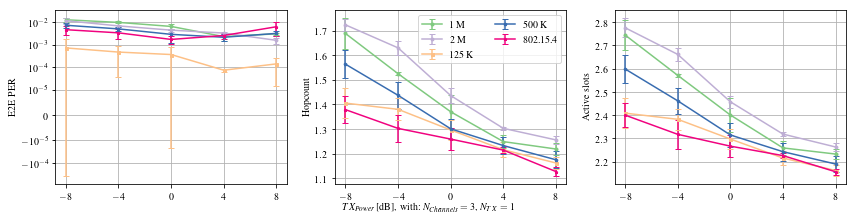

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed/evaluate_txpower_plot_graztestbed_ntx_2_exp_23245_32227.pdf


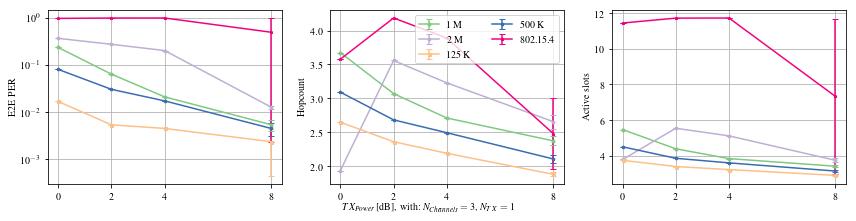

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/evaluate_txpower_plot_cautestbed_ntx_3_exp_1148_1639.pdf


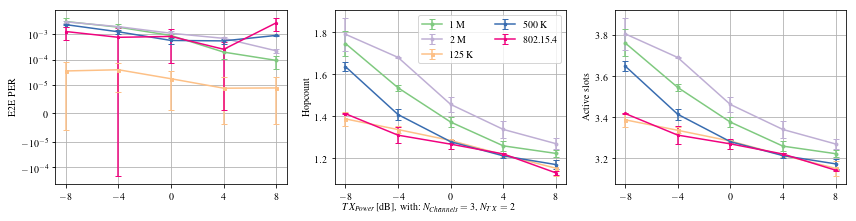

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed/evaluate_txpower_plot_graztestbed_ntx_3_exp_23245_32227.pdf


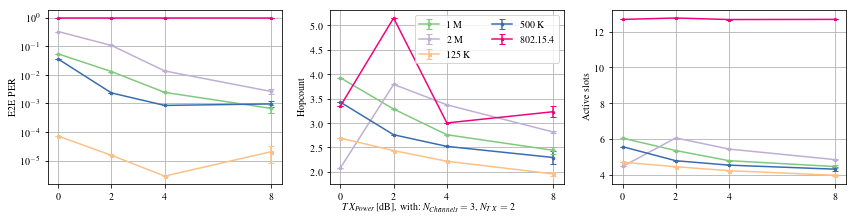

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/evaluate_txpower_plot_cautestbed_ntx_4_exp_1148_1639.pdf


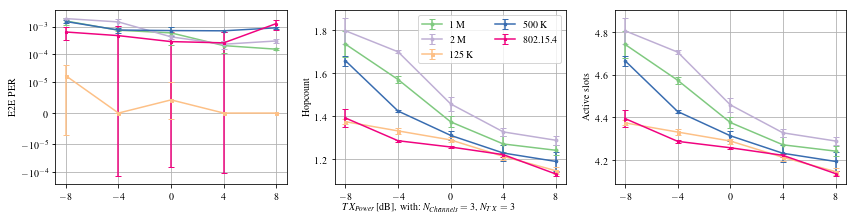

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed/evaluate_txpower_plot_graztestbed_ntx_4_exp_23245_32227.pdf


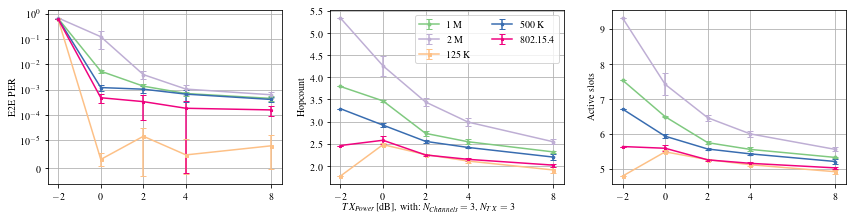

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/evaluate_txpower_plot_cautestbed_ntx_8_exp_1148_1639.pdf


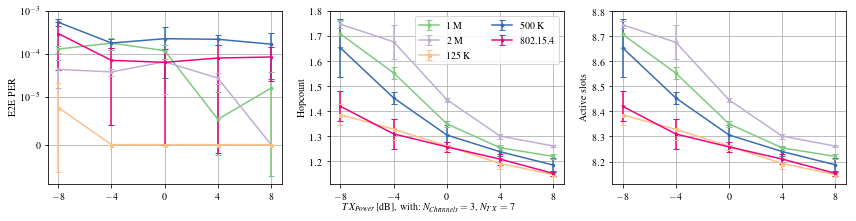

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed/evaluate_txpower_plot_graztestbed_ntx_8_exp_23245_32227.pdf


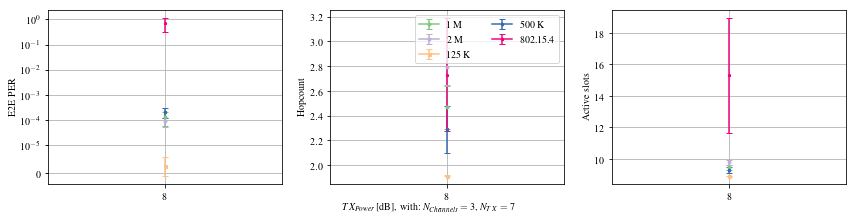

In [95]:
### note that the actual number of transmissions is ntx - 1!!! The plot labels are fixed accordingly
def plot_summary_testbed_ntx(testbed, parameters, startexp, endexp):
  [txoffset0, capture0, packet_size0, nch0, och0, ntx0] = parameters
  testbed = str(testbed).lower()
  wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/%s_testbed" %(testbed)
  plotfilename="evaluate_txpower_plot_%stestbed_ntx_%d_exp_%d_%d.pdf" % (testbed, ntx0, startexp, endexp)
  file_name = os.path.join(wdirg, plotfilename)
  print "plotting: " + file_name
  plot_summary_plots(globals()["txpowerdata_%s_ntx" % (testbed)][ntx0], blemodes, file_name, parameters)

[txoffset0, capture0, packet_size0, nch0, och0, ntx0] = [0, 0, 38, 3, 0, 8]
for ntx0 in ntxx:
  plot_summary_testbed_ntx("cau", [txoffset0, capture0, packet_size0, nch0, och0, ntx0], startexpcau, maxjobid_cau)
  plot_summary_testbed_ntx("graz", [txoffset0, capture0, packet_size0, nch0, och0, ntx0], startexpgraz, maxjobid_graz)

# wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/home_testbed"
# plotfilename="evaluate_txpower_plot_hometestbed_ntx_%d_exp_%d_%d.pdf" % (ntx0, startexphome, maxjobid_home)
# file_name = os.path.join(wdirg, plotfilename)
# print "plotting: " + file_name
# plot_summary_plots(txpowerdata_home, blemodes, file_name)


In [98]:
def plot_summary_boxplots(txpowerdata, blemodes, file_name):
  capsize=3
  markersize=3
  linewidth=1.5
  linestyle=linestyles[0]
  norm = matplotlib.colors.Normalize(vmin=0, vmax=len(blemodes)+1)

  #fig = plt.figure(figsize=(4, 6))  #width, height
  fig, axx = plt.subplots(ncols=3, sharey=False, sharex=True, figsize=(12,3))
  #axmain = fig.add_subplot(111,frameon=False)
  # Turn off axis lines and ticks of the big subplot
  #axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
  #axx[1].set_ylim(80, 100.5)

  for counter, ble_mode in enumerate(blemodes):
    color=plt.get_cmap('Accent')(norm(counter))
    marker=markers[counter]
  #   if res != 0:
  #     txp_per_err = list(np.asarray(txpowerdata[ble_mode]["perstd"]) + res)
  #     txp_per =  list(np.asarray(txpowerdata[ble_mode]["per"]) + res)
  #   #   yerr = np.log10(txp_per_err)
  #   #   y=np.log10(txp_per)
  #     yerr = txp_per_err
  #     y=txp_per
  #   else:
      #shallow copy
    yerr=copy.copy(txpowerdata[ble_mode]["perstd"])
    y=copy.copy(txpowerdata[ble_mode]["per"])
    yerr1=copy.copy(txpowerdata[ble_mode]["hopcountstd"])
    y1=copy.copy(txpowerdata[ble_mode]["hopcount"])
    yerr2=copy.copy(txpowerdata[ble_mode]["onslotsstd"])
    y2=copy.copy(txpowerdata[ble_mode]["onslots"])
    axx[0].errorbar(txpowerdata[ble_mode]["x"], y, yerr=yerr, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    #axx[0].boxplot(y, positions=txpowerdata[ble_mode]["x"], notch=True)
    axx[1].errorbar(txpowerdata[ble_mode]["x"], y1, yerr=yerr1, label=ble_mode_str_dict[ble_mode], linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    #axx[1].boxplot(y1, positions=txpowerdata[ble_mode]["x"], notch=True)
    axx[2].errorbar(txpowerdata[ble_mode]["x"], y2, yerr=yerr2, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    #axx[2].boxplot(y2, positions=txpowerdata[ble_mode]["x"], notch=True)

    axx[0].set_yscale('symlog', linthreshy=0.00001)
    axx[1].legend(loc="best",  ncol=2)
    
  ylabels=["E2E PER", "Hopcount", "Active slots"]
  for i, ax in enumerate(axx):
    ax.grid()
    # axx.set_yscale('log')
    #ax.set_xlim(min(txpowerdata[ble_mode]["x"])-0.2, max(txpowerdata[ble_mode]["x"])+0.2)
  #   ax.set_xlabel('TX power [dB]')
    ax.set_ylabel(ylabels[i])

  x_lbl="$TX_{Power}$ [dB], with: $N_{Channels}=%d$, $N_{TX}=%d$" %(nch0, ntx0-1)
  fig.text(0.5, 0.00, x_lbl, ha='center')
  fig.tight_layout()
  # plt.subplots_adjust(left=0, top=2)
  plt.savefig(file_name, bbox_inches='tight')
  plt.show()

In [ ]:
startexp=23245
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
plotfilename="evaluate_txpower_boxplot_graztestbed-%d.pdf" % startexp
file_name = os.path.join(wdirg, plotfilename)
print "plotting: " + file_name
plot_summary_boxplots(txpowerdata_graz, blemodes, file_name)

startexp=1
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
plotfilename="evaluate_txpower_boxplot_cautestbed-%d.pdf" % startexp
file_name = os.path.join(wdirg, plotfilename)
print "plotting: " + file_name
plot_summary_boxplots(txpowerdata_cau, blemodes, file_name)

wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/home_testbed"
plotfilename="evaluate_txpower_boxplot_hometestbed-%d.pdf" % startexp
file_name = os.path.join(wdirg, plotfilename)
print "plotting: " + file_name
plot_summary_boxplots(txpowerdata_home, blemodes, file_name)

In [3]:
### Parse experiment and save results
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
exp_path = os.path.join(wdirg, "logs_23263")
nodes = load_testbed_node_log_files(exp_path);
saveObject(nodes, os.path.join(exp_path, "nodes.pickle"))       

In [ ]:
### Load parsed results
expid=23252
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
exp_path = os.path.join(wdirg, "logs_%d" % (expid))
nodes = loadObject(os.path.join(exp_path, "nodes.pickle"))    

In [42]:
#y1 is plotted on log scale axis
def plot_exp(x, xticks, x_lbl, lbl, y1, yerr1, y2, yerr2, y3, yerr3, ylabels, expn, wdirg, color, fig=None, axx=None, marker='*'):
  capsize=3
  markersize=3
  linewidth=1.5
  linestyle=linestyles[0]
  #color='b'

  #fig = plt.figure(figsize=(4, 6))  #width, height
  if fig is None or axx is None:
    fig, axx = plt.subplots(ncols=3, sharey=False, sharex=True, figsize=(12,3))
#   plotfilename="plot_graztestbed_exp%d.pdf" % expn
#   file_name = os.path.join(wdirg, plotfilename)
  #print "plotting: " + x_lbl + ", " + lbl
  axx[0].errorbar(x, y1, yerr=yerr1, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  axx[1].errorbar(x, y2, yerr=yerr2, label=lbl, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  axx[2].errorbar(x, y3, yerr=yerr3, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  #log scale, but make a linear region around zero to avoid problems with zero, as log(0) is nan
  axx[0].set_yscale('symlog', linthreshy=0.00001)
  axx[1].legend(loc="best",  ncol=1)

  for i, ax in enumerate(axx):
    ax.grid()
    #ax.set_xlim(min(txpowerdata[ble_mode]["x"])-0.2, max(txpowerdata[ble_mode]["x"])+0.2)
    ax.set_ylabel(ylabels[i])
    ax.set_xticks(x, minor=True)
    ax.set_xticklabels(xticks, minor=True)
    #ax.set_xticklabels(xticks[0:10:len(xticks)], minor=False)

    ax.minorticks_off()

  if x_lbl is not None:
    fig.text(0.5, 0.00, x_lbl, ha='center')
  fig.tight_layout()
  #plt.savefig(file_name, bbox_inches='tight')
  #plt.show()
  return fig, axx

In [101]:
#plot for one tx power
def plot_micro_view_for_txpowers(expdict, expdesc, startexp, blemodes, txpowerset, params, plotnametemplate, wdirg):
  [txoffset0, capture0, packet_size0, nch0, och0, ntx0]=params
  norm = matplotlib.colors.Normalize(vmin=0, vmax=len(blemodes)+1)
  ncols=4
  for txpower0 in txpowerset:
    fig, axx = plt.subplots(ncols=ncols, sharey=False, sharex=False, figsize=(4*ncols,3))
    x_lbl_written = False
    for expid in expdesc.keys():
      if expid >= startexp:
        [ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = expdesc[expid]
        if [txpower, txoffset, capture, packet_size, nch, och, ntx] == [txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0]:
          nodes=expdict[expid].copy()
          nodeids=list(nodes.keys())
          nodeids.sort()
          x = range(0, len(nodeids), 1)

          y1 = [nodes[i]["PER"] if nodes[i]["PER"] != -1 else 0 for i in nodeids ]
          #yerr1 = np.std(y1)
          yerr1 = None   

#           syncslots = [list(np.asarray(nodes[i]["sync"].values()))]
          syncslots = [nodes[i]["all"].values() for i in nodeids]
          syncslots = [[ d[1] for d in row if not d[0] ] for row in syncslots ]
##         print syncslots
          syncslots_flat = list(itertools.chain(*syncslots))
          y2 = [nodes[i]["hopcount"][2] if nodes[i]["hopcount"][2] > -1 else 0 for i in nodeids]
          yerr2 = [nodes[i]["hopcount"][3] if nodes[i]["hopcount"][2] > -1 else 0 for i in nodeids]
          #print syncslots
#           y2 = np.mean(syncslots ,axis=1)
#           y2 = [np.mean(s) if len(s)>0 else 0 for s in syncslots]
#           yerr2 = [np.std(s) if len(s)>0 else 0 for s in syncslots]

#           y3 = [np.mean(nodes[i]["tot"].values()) for i in nodeids]
#           yerr3 = [np.std(nodes[i]["tot"].values()) for i in nodeids]
          y3 = [nodes[i]["totslots"][2] if nodes[i]["totslots"][2] > -1 else 0 for i in nodeids]
          yerr3 = [nodes[i]["totslots"][3] if nodes[i]["totslots"][2] > -1 else 0 for i in nodeids]
    
          color=plt.get_cmap('Accent')(norm(blemodes.index(ble_mode)))
          lbl = ble_mode_str_dict[ble_mode]
          #x_lbl0="Experiment %d, Node IDs" % expid
          x_lbl0="Node index. Parameters: $TX_{Power}$=%d dB, $N_{Channels}=%d$, $N_{TX}=%d$" %(txpower0, nch0, ntx0-1)
          if not x_lbl_written:
            x_lbl = x_lbl0
            x_lbl_written = True
          else:
            x_lbl=None
          ylabels=["E2E PER", "Hopcount", "Active slots", "Sync slot Histogram", "Sync slot CDF"]
          print "plotting: " + x_lbl0 + ", " + lbl
          plot_exp(x, nodeids, x_lbl, lbl, y1, yerr1, y2, yerr2, y3, yerr3, ylabels, expid, wdirg, color, marker=markers[blemodes.index(ble_mode)], fig=fig, axx=axx)

          n_bins=int(np.max(syncslots_flat))
          #print syncslots
          linewidth=1.5
          n, bins, patches = axx[3].hist(syncslots_flat, n_bins, density=True, histtype='step',cumulative=True, color=color, linewidth=linewidth)
          axx[3].set_xticks(bins, minor=True)
          axx[3].set_xticklabels(bins, minor=True)
          axx[3].minorticks_off()
          axx[3].grid()
          axx[3].grid()
  #         bin_edges, cdf, hist = do_cdf(chain)
  #         axx[4].errorbar(bin_edges, cdf, color=color, linestyle=linestyle, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  #         axx[4].set_xticks(bin_edges, minor=True)
  #         axx[4].set_xticklabels(bin_edges, minor=True)

    plotfilename= plotnametemplate % txpower0
    file_name = os.path.join(wdirg, plotfilename)
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

In [100]:
#plot for one rf mode
def plot_micro_view_for_rfmodes(expdict, expdesc, startexp, blemodes, txpowerset, params, plotnametemplate, wdirg):
  [txoffset0, capture0, packet_size0, nch0, och0, ntx0]=params
  norm = matplotlib.colors.Normalize(vmin=min(txpowerset), vmax=max(txpowerset)+1)
  ncols=4
  ble_mode_name=0
  for ble_mode0 in blemodes:
    fig, axx = plt.subplots(ncols=ncols, sharey=False, sharex=False, figsize=(4*ncols,3))
    x_lbl_written=False
    for expid in expdesc.keys():
      if expid >= startexp:
        [ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = expdesc[expid]
        if (txpower in txpowerset) and ([ble_mode, txoffset, capture, packet_size, nch, och, ntx] == [ble_mode0, txoffset0, capture0, packet_size0, nch0, och0, ntx0]):
          ble_mode_name=ble_mode
          nodes=expdict[expid].copy()
          nodeids=list(nodes.keys())
          nodeids.sort()
          x = range(0, len(nodeids), 1)

          y1 = [nodes[i]["PER"] if nodes[i]["PER"] != -1 else 0 for i in nodeids ]
          #yerr1 = np.std(y1)
          yerr1 = None

          syncslots = [list(nodes[i]["all"].values()) for i in nodeids]
          syncslots = [[ d[1] for d in row if not d[0] ] for row in syncslots  ]
          
          syncslots_flat = list(itertools.chain(*syncslots))
          y2 = [np.mean(s) if len(s)>0 else 0 for s in syncslots]
          yerr2 = [np.std(s) if len(s)>0 else 0 for s in syncslots]
#           print len(y2), len(x)
#           print yerr2
#           syncslots = [list(np.asarray(nodes[i]["sync"].values()) + 1) if not nodes[i]["is_initiator"] else list(nodes[i]["sync"].values()) for i in nodeids]
#           syncslots_flat = list(itertools.chain(*syncslots))
#           y2 = [np.mean(s) for s in syncslots]
#           yerr2 = [np.std(s) for s in syncslots]

          y3 = [np.mean(nodes[i]["tot"].values()) for i in nodeids]
          yerr3 = [np.std(nodes[i]["tot"].values()) for i in nodeids]

          color=plt.get_cmap('Accent')(norm(txpower))
          lbl="$TX_{Power}$ %d dB" %(txpower)
          #x_lbl0="Experiment %d, Node IDs" % expid
          x_lbl0="Node index. Parameters: Mode: %s, $N_{Channels}=%d$, $N_{TX}=%d$" %(ble_mode_str_dict[ble_mode], nch, ntx-1)
          if not x_lbl_written:
            x_lbl = x_lbl0
            x_lbl_written = True
          else:
            x_lbl=None
          ylabels=["E2E PER", "Hopcount", "Active slots", "Sync slot Histogram", "Sync slot CDF"]
          print "plotting: " + x_lbl0 + ", " + lbl
          plot_exp(x, nodeids, x_lbl, lbl, y1, yerr1, y2, yerr2, y3, yerr3, ylabels, expid, wdirg, color, marker=markers[0], fig=fig, axx=axx)

          n_bins=int(np.max(syncslots_flat))
          #print syncslots
          linewidth=1.5
          n, bins, patches = axx[3].hist(syncslots_flat, n_bins, density=True, histtype='step',cumulative=True, color=color, linewidth=linewidth)
          axx[3].set_xticks(bins, minor=True)
          axx[3].set_xticklabels(bins, minor=True)
          axx[3].minorticks_off()
          axx[3].grid()
          axx[3].grid()
  #         bin_edges, cdf, hist = do_cdf(chain)
  #         axx[4].errorbar(bin_edges, cdf, color=color, linestyle=linestyle, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  #         axx[4].set_xticks(bin_edges, minor=True)
  #         axx[4].set_xticklabels(bin_edges, minor=True)

    plotfilename= plotnametemplate % ble_mode_str_dict[ble_mode_name]
    file_name = os.path.join(wdirg, plotfilename)
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

plotting: Node index. Parameters: $TX_{Power}$=0 dB, $N_{Channels}=3$, $N_{TX}=4$, 1 M
plotting: Node index. Parameters: $TX_{Power}$=0 dB, $N_{Channels}=3$, $N_{TX}=4$, 2 M
plotting: Node index. Parameters: $TX_{Power}$=0 dB, $N_{Channels}=3$, $N_{TX}=4$, 125 K
plotting: Node index. Parameters: $TX_{Power}$=0 dB, $N_{Channels}=3$, $N_{TX}=4$, 500 K
plotting: Node index. Parameters: $TX_{Power}$=0 dB, $N_{Channels}=3$, $N_{TX}=4$, 802.15.4
plotting: Node index. Parameters: $TX_{Power}$=0 dB, $N_{Channels}=3$, $N_{TX}=4$, 1 M
plotting: Node index. Parameters: $TX_{Power}$=0 dB, $N_{Channels}=3$, $N_{TX}=4$, 2 M
plotting: Node index. Parameters: $TX_{Power}$=0 dB, $N_{Channels}=3$, $N_{TX}=4$, 125 K
plotting: Node index. Parameters: $TX_{Power}$=0 dB, $N_{Channels}=3$, $N_{TX}=4$, 500 K
plotting: Node index. Parameters: $TX_{Power}$=0 dB, $N_{Channels}=3$, $N_{TX}=4$, 802.15.4
plotting: Node index. Parameters: $TX_{Power}$=0 dB, $N_{Channels}=3$, $N_{TX}=4$, 125 K
plotting: Node index. P

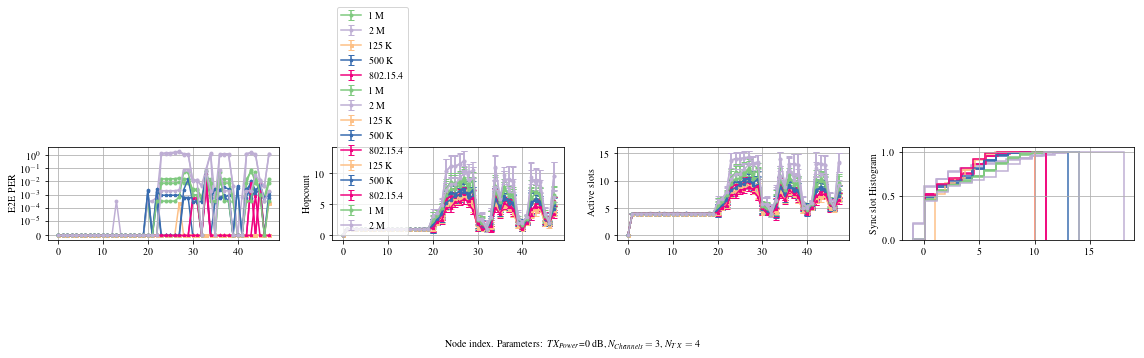

plotting: Node index. Parameters: $TX_{Power}$=2 dB, $N_{Channels}=3$, $N_{TX}=4$, 1 M
plotting: Node index. Parameters: $TX_{Power}$=2 dB, $N_{Channels}=3$, $N_{TX}=4$, 2 M
plotting: Node index. Parameters: $TX_{Power}$=2 dB, $N_{Channels}=3$, $N_{TX}=4$, 125 K
plotting: Node index. Parameters: $TX_{Power}$=2 dB, $N_{Channels}=3$, $N_{TX}=4$, 500 K
plotting: Node index. Parameters: $TX_{Power}$=2 dB, $N_{Channels}=3$, $N_{TX}=4$, 802.15.4
plotting: Node index. Parameters: $TX_{Power}$=2 dB, $N_{Channels}=3$, $N_{TX}=4$, 1 M
plotting: Node index. Parameters: $TX_{Power}$=2 dB, $N_{Channels}=3$, $N_{TX}=4$, 2 M
plotting: Node index. Parameters: $TX_{Power}$=2 dB, $N_{Channels}=3$, $N_{TX}=4$, 125 K
plotting: Node index. Parameters: $TX_{Power}$=2 dB, $N_{Channels}=3$, $N_{TX}=4$, 500 K
plotting: Node index. Parameters: $TX_{Power}$=2 dB, $N_{Channels}=3$, $N_{TX}=4$, 802.15.4
plotting: Node index. Parameters: $TX_{Power}$=2 dB, $N_{Channels}=3$, $N_{TX}=4$, 1 M
plotting: Node index. Par

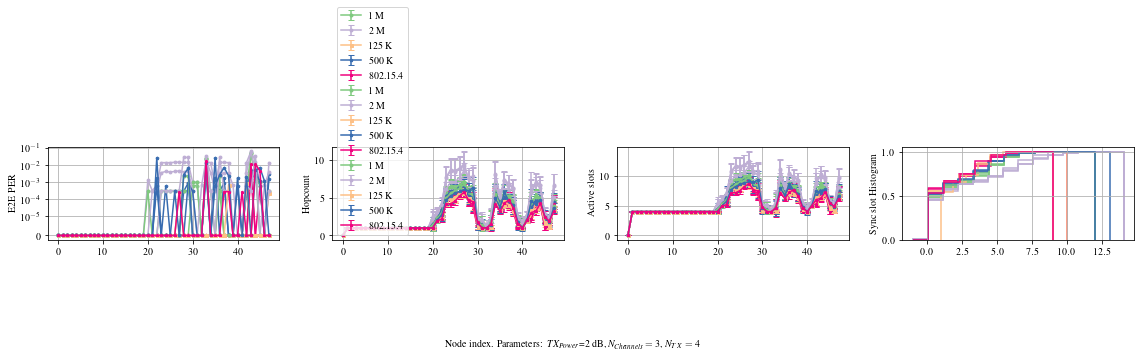

plotting: Node index. Parameters: $TX_{Power}$=4 dB, $N_{Channels}=3$, $N_{TX}=4$, 1 M
plotting: Node index. Parameters: $TX_{Power}$=4 dB, $N_{Channels}=3$, $N_{TX}=4$, 2 M
plotting: Node index. Parameters: $TX_{Power}$=4 dB, $N_{Channels}=3$, $N_{TX}=4$, 125 K
plotting: Node index. Parameters: $TX_{Power}$=4 dB, $N_{Channels}=3$, $N_{TX}=4$, 500 K
plotting: Node index. Parameters: $TX_{Power}$=4 dB, $N_{Channels}=3$, $N_{TX}=4$, 802.15.4
plotting: Node index. Parameters: $TX_{Power}$=4 dB, $N_{Channels}=3$, $N_{TX}=4$, 1 M
plotting: Node index. Parameters: $TX_{Power}$=4 dB, $N_{Channels}=3$, $N_{TX}=4$, 2 M
plotting: Node index. Parameters: $TX_{Power}$=4 dB, $N_{Channels}=3$, $N_{TX}=4$, 125 K
plotting: Node index. Parameters: $TX_{Power}$=4 dB, $N_{Channels}=3$, $N_{TX}=4$, 500 K
plotting: Node index. Parameters: $TX_{Power}$=4 dB, $N_{Channels}=3$, $N_{TX}=4$, 802.15.4
plotting: Node index. Parameters: $TX_{Power}$=4 dB, $N_{Channels}=3$, $N_{TX}=4$, 1 M
plotting: Node index. Par

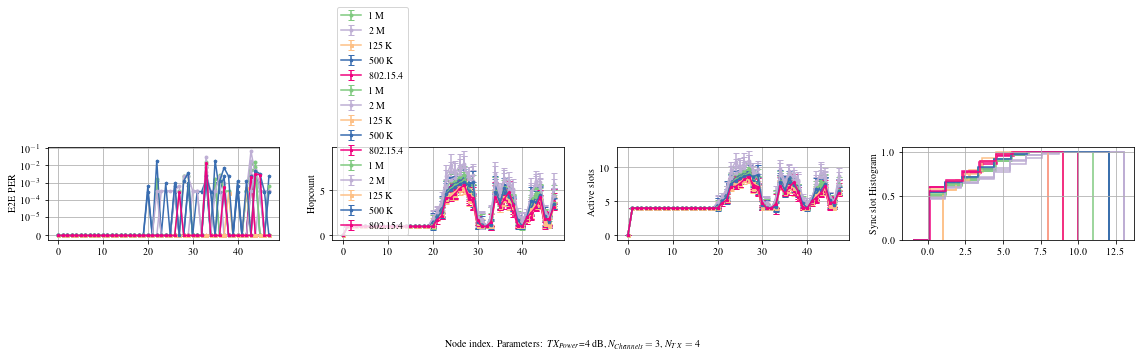

plotting: Node index. Parameters: Mode: 1 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 1 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 1 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB
plotting: Node index. Parameters: Mode: 1 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 1 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 1 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB
plotting: Node index. Parameters: Mode: 1 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 1 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB
plotting: Node index. Parameters: Mode: 1 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB


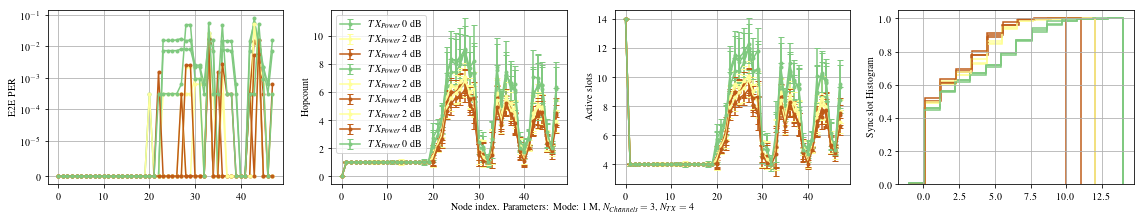

plotting: Node index. Parameters: Mode: 2 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 2 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 2 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB
plotting: Node index. Parameters: Mode: 2 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 2 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 2 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB
plotting: Node index. Parameters: Mode: 2 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 2 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB
plotting: Node index. Parameters: Mode: 2 M, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB


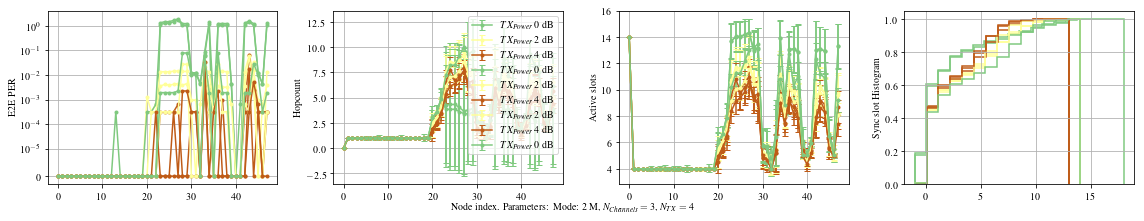

plotting: Node index. Parameters: Mode: 125 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 125 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 125 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB
plotting: Node index. Parameters: Mode: 125 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 125 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 125 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB
plotting: Node index. Parameters: Mode: 125 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 125 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 125 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB


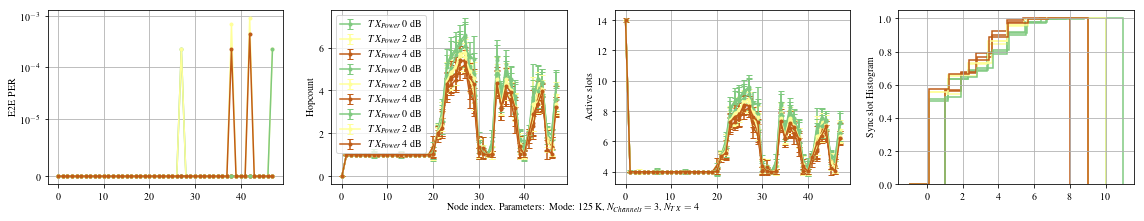

plotting: Node index. Parameters: Mode: 500 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 500 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 500 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB
plotting: Node index. Parameters: Mode: 500 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 500 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 500 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB
plotting: Node index. Parameters: Mode: 500 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 500 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 500 K, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB


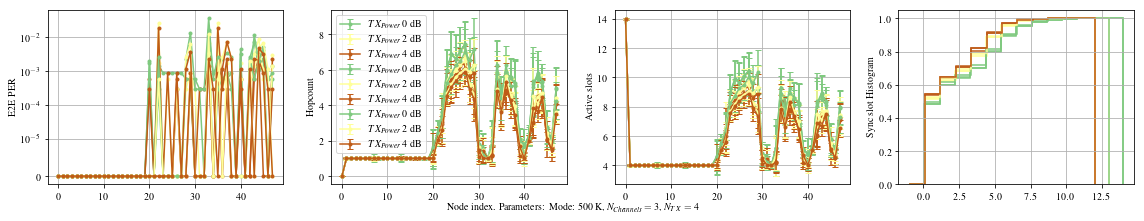

plotting: Node index. Parameters: Mode: 802.15.4, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 802.15.4, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 802.15.4, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB
plotting: Node index. Parameters: Mode: 802.15.4, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 802.15.4, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 802.15.4, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB
plotting: Node index. Parameters: Mode: 802.15.4, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 0 dB
plotting: Node index. Parameters: Mode: 802.15.4, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 2 dB
plotting: Node index. Parameters: Mode: 802.15.4, $N_{Channels}=3$, $N_{TX}=4$, $TX_{Power}$ 4 dB


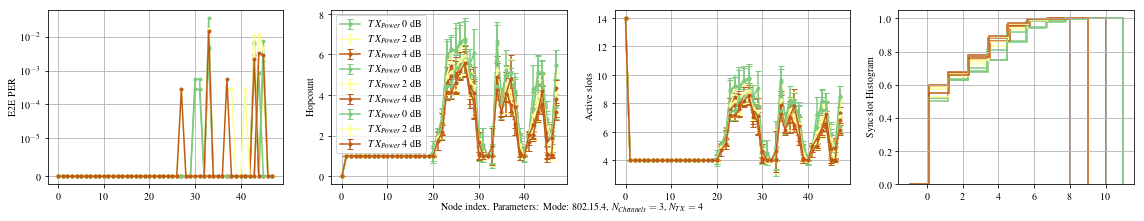

In [64]:
startexp=23245
blemodes = ble_mode_str_dict.keys()
blemodes.sort()
[txoffset0, capture0, packet_size0, nch0, och0, ntx0] = [0, 0, 38, 3, 0, 4]
params=[txoffset0, capture0, packet_size0, nch0, och0, ntx0]
txpowerset=[0, 2, 4, 8]
plotnametemplate = "plot_graztestbed_exp_txpower_%d.pdf"
plot_micro_view_for_txpowers(expdict_graz, expdesc_graz, startexp, blemodes, txpowerset, params, plotnametemplate, wdirg)

plotnametemplate = "plot_graztestbed_exp_rfmode_%s.pdf"
plot_micro_view_for_rfmodes(expdict_graz, expdesc_graz, startexp, blemodes, txpowerset, params, plotnametemplate, wdirg)

In [ ]:
blemodes = ble_mode_str_dict.keys()
blemodes.sort()
[txoffset0, capture0, packet_size0, nch0, och0, ntx0] = [0, 0, 38, 3, 0, 4]
txpowerset=[0, 2, 4]
params=[txoffset0, capture0, packet_size0, nch0, och0, ntx0]


In [130]:
### Do some stats on parsed results
hopcounts = [d["hopcount"] for d in list(nodes.values())]
per = [d["PER"] for d in list(nodes.values())]
print ' ', np.average(hopcounts, axis=0), np.std(hopcounts, axis=0), np.percentile(hopcounts, 70, axis=0)
print ' ',  100*np.average(per, axis=0), 100*np.std(per, axis=0), 100*np.min(per, axis=0), \
100*np.max(per, axis=0)
# Absolute mean deviation 
avg_per=np.mean(per)
stddev_per=np.std(per)
print ' Avg PER, std dev, Absolute mean deviation', 100*avg_per, 100*stddev_per, 100*np.mean(np.absolute(per - avg_per)) 

  [1.91666667 4.625      2.38166555 0.34668013] [1.32024829 3.02506887 1.78377485 0.34012608] [2.9        7.         3.61645081 0.52920302]
  0.0 0.0 0.0 0.0
 Avg PER, std dev, Absolute mean deviation 0.0 0.0 0.0


In [ ]:
def do_cdf(series):
  ### from https://blog.finxter.com/numpy-cumsum/
  # s=Size of our data
  series_size=len(series)
  # Sort the data and set bins edges
  sorted_series = np.sort(series)
  bins = np.append(sorted_series, sorted_series[-1]+1)
  # Use the histogram function to bin the data
  hist1, bin_edges = np.histogram(series, bins = bins)
  # Account for the possible float data
  hist = hist1.astype(float)/series_size
  # Find the cdf
  cdf = np.cumsum(hist)
  return bin_edges[1:], cdf, hist1

def do_percentile(series):
  p=list()
  r=range(0,101,10)
  for i in r:
    p.append(np.percentile(series, i, axis=0))
  return r, p

# plot the cumulative histogram
x=hopcounts[3]
n_bins=int(np.max(x))
print x, n_bins
n, bins, patches = plt.hist(x, n_bins, density=True, histtype='step',cumulative=True, label='Empirical')
plt.show()

bin_edges, cdf, hist = do_cdf(hopcounts[3])
r, p = do_percentile(hopcounts[3])
# Plot the cdf
plt.plot(bin_edges, hist)
plt.show()
# Plot the cdf
plt.plot(bin_edges, cdf)
plt.show()
plt.plot(cdf, bin_edges)
plt.show()
plt.plot(r,p)
plt.show()

In [34]:
for lline in [":A..--CC...", ":B---CCC--.....", ":-BBBBBBBB.....", ":B--------.....",":A.......-BBBB."]:
  lline=str(lline)
  is_initiator=False; synced=-1; sync_slot=-1; tot=0
  if len(lline) > 1: #and len(lline) <= Round.ROUND_LEN+1:
#                 if(len(lline)<Round.ROUND_LEN):
#                     lline = lline.rjust(Round.ROUND_LEN+ 1, "A")
#                     lline=lline.replace(':','A') #replace 
    ch=lline[1]
    #replace left dots with the letter, and remove the right dots!
    lline=re.sub(r'\.*$',r'',lline) #remove trailing dots
    lline=lline.replace('.',ch) #replace left dots with the first letter
    tx_status = lline[1:]  #remove ":"                  
    #print self.tx_status
    synced = tx_status.find("-") 
    sync_slot = 1 + synced if synced != -1 else -1  #first rx ok
    is_initiator = tx_status[0] in ['B', '1', '2']
    if is_initiator:
      sync_slot = 0

    tot=len(tx_status)
    
  print lline, is_initiator, sync_slot, tot 


:AAA--CC False 4 7
:B---CCC-- True 0 9
:-BBBBBBBB False 1 9
:B-------- True 0 9
:AAAAAAAA-BBBB False 9 13


In [126]:
#! open -a Preview /Users/beshr/work/chaos/examples/nrf-glossy/exp-logs/evaluate_*.pdf
#wdir="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
! open -a Preview /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/*.pdf
#! open -a Preview /Users/beshr/work/chaos/examples/nrf-glossy/exp-logs/evaluate_txpower_plot0.pdf

In [90]:
a=[2,1,0]
a=np.asarray(a)
b=9
c=list()
c.append(b)
c.append(b-1)
c.append(b+1)
print a, c
idx=np.argsort(a)
a.sort()
c = np.asarray(c)
c = c[idx]
print a, c


[2 1 0] [9, 8, 10]
[0 1 2] [10  8  9]
